In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from clearml import Task


In [2]:
task = Task.init(project_name="bogdoll/Anomaly_detection_Moritz", task_name="example_run", reuse_last_task_id=False)
task.set_base_docker(
            "tks-zx-01.fzi.de/autonomous-agents/core-carla:21.10",
            docker_setup_bash_script="apt-get update && apt-get install -y python3-opencv",
            docker_arguments="-e NVIDIA_DRIVER_CAPABILITIES=all",  # --ipc=host",
        )
# PyTorch fix for version 1.10, see https://github.com/pytorch/pytorch/pull/69904
# task.add_requirements(
#     package_name="setuptools",
#     package_version="59.5.0",
# )
# task.add_requirements(
#     package_name="moviepy",
#     package_version="1.0.3",
# )

ClearML Task: created new task id=f7770ec8a69344d4a5204e1efa8f3a4b
ClearML results page: https://tks-zx.fzi.de:8080/projects/013741c08abc4e298d7346004c9c73dd/experiments/f7770ec8a69344d4a5204e1efa8f3a4b/output/log


In [3]:
mnist_train = datasets.FashionMNIST(root='fashion_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.FashionMNIST(root='fashion_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


In [4]:
## exclude label
def discardLabels(data):
    new_data = []
    for img, _ in data:
        new_data.append(img)
        
    return np.array(new_data)

mnist_train = discardLabels(mnist_train)
mnist_test = discardLabels(mnist_test)

2022-05-24 12:57:14,882 - clearml.Task - INFO - No repository found, storing script code instead


/tmp/fzi-is789/ipykernel_1241699/537219179.py:7: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/tmp/fzi-is789/ipykernel_1241699/537219179.py:7: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [5]:
## apply noise
noise_set = []

for img in mnist_test:
    pic = img.numpy().copy()
    pic[:,10:15,:] = 0.0
    noise_set.append(pic)

noise_set = np.array(noise_set)
noise_set = torch.as_tensor(noise_set)
noise_set.shape

torch.Size([10000, 1, 28, 28])

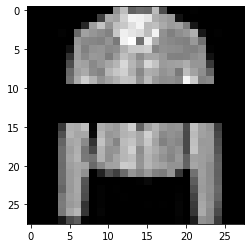

In [6]:
## show noisy image

img = noise_set[10]
img = img.squeeze()
img = img.numpy()
plt.imshow(img, cmap="gray")

torch.Size([28, 28])


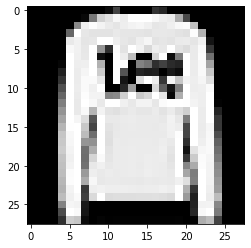

In [7]:
img = mnist_test[1]
img = img.squeeze()
print(img.shape)
plt.imshow(img.squeeze(), cmap="gray")

In [8]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [9]:
from torch.utils.data import DataLoader

dataloaders = {}
dataloaders["train"] = DataLoader(dataset=mnist_train,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["test"] = DataLoader(dataset=mnist_test,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["noise"] = DataLoader(dataset=noise_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)


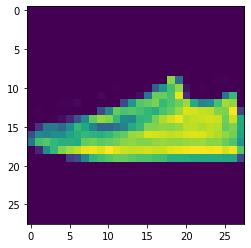

In [10]:
images = next(iter(dataloaders["test"]))
plt.imshow(images[0].squeeze())

In [11]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=128*20*20, zDim=20):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 3)
        self.encConv2 = nn.Conv2d(16, 32, 3)
        self.encConv3 = nn.Conv2d(32, 64, 3)
        self.encConv4 = nn.Conv2d(64, 128, 3)
#         self.encConv5 = nn.Conv2d(128, 256, 3)
#         self.encConv6 = nn.Conv2d(256, 512, 3)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
#         self.decConv1 = nn.ConvTranspose2d(512, 256, 5)
#         self.decConv2 = nn.ConvTranspose2d(256, 128, 3)
        self.decConv3 = nn.ConvTranspose2d(128, 64, 3)
        self.decConv4 = nn.ConvTranspose2d(64, 32, 3)
        self.decConv5 = nn.ConvTranspose2d(32, 16, 3)
        self.decConv6 = nn.ConvTranspose2d(16, imgChannels, 3)
        
        self.flatten = 0

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
#         print(x.size())
        x = F.relu(self.encConv2(x))
#         print(x.size())
        x = F.relu(self.encConv3(x))
#         print(x.size())
        x = F.relu(self.encConv4(x))
#         print(x.size())
#         x = F.relu(self.encConv5(x))
#         print(x.size())
# #         x = F.relu(self.encConv6(x))
#         print(x.size())
        self.flatten = x.size(1) * x.size(2) * x.size(3)
#         print(self.flatten)
        x = x.view(-1, self.flatten)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 128, 20, 20)
#         x = F.relu(self.decConv1(x))
#         x = F.relu(self.decConv2(x))
        x = F.relu(self.decConv3(x))
        x = F.relu(self.decConv4(x))
        x = F.relu(self.decConv5(x))
        x = torch.sigmoid(self.decConv6(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [12]:
from torch import optim
import torch.nn.functional as  F
def loss_fn(x, recon_x, mu, log_var):
    Recon_loss = F.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction = "sum")
    KLD_loss = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 - log_var)
    return Recon_loss + KLD_loss


model = VAE()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-03)


In [13]:
print(model)

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (encConv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (encConv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (encFC1): Linear(in_features=51200, out_features=20, bias=True)
  (encFC2): Linear(in_features=51200, out_features=20, bias=True)
  (decFC1): Linear(in_features=20, out_features=51200, bias=True)
  (decConv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (decConv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (decConv5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (decConv6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
epoch = 30
train_losses = []
val_losses = []


for e in range(1, epoch+1):
    if epoch > 1:
        task.execute_remotely('docker', clone=False, exit_process=True)

    train_loss = 0.0
    for x in dataloaders["train"]:
        x = x.to(device)
        x_recon, mu, log_var = model(x)

        optimizer.zero_grad()
        loss = loss_fn(x, x_recon, mu, log_var)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    val_loss = 0.0
    for x in dataloaders["test"]:
        x = x.to(device)
        x_recon, mu, log_var = model(x)

        optimizer.zero_grad()
        loss = loss_fn(x, x_recon, mu, log_var)

        val_loss += loss.item()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_loss /= len(dataloaders["train"].dataset)
    val_loss /= len(dataloaders["test"].dataset)

    print(f"Epoch {e} | Loss: {train_loss} | V_Loss: {val_loss}")


2022-05-24 12:57:30,124 - clearml - WARNING - Switching to remote execution, output log page https://tks-zx.fzi.de:8080/projects/013741c08abc4e298d7346004c9c73dd/experiments/f7770ec8a69344d4a5204e1efa8f3a4b/output/log


In [ ]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def printReconError(img_in, img_out, threshold=None):
    errorMatrix = np.absolute(img_in - img_out)
    if not threshold == None:
        errorMatrix[errorMatrix < threshold] = 0.0
    errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1])
    print(f"MAE: {errorAvg}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Original")
    ax1.imshow(img_in, cmap="gray")
    ax2.set_title("Recreation")
    ax2.imshow(img_out, cmap="gray")
    ax3.set_title("ErrorMap")
    ax3.imshow(errorMatrix, cmap="gray")

In [ ]:
import random

model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["noise"]), 1):
        imgs = imgs.to(device)
#         plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (1,2,0))
#         plt.imshow(img, cmap="gray")
        
        out, mu, logVAR = model(imgs)
#         plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (1,2,0))
#         plt.imshow(out, cmap="gray")
        
        printReconError(img, out, 0.4)
        break

In [ ]:
tmp = []
tmp.append(img)
tmp = np.array(tmp)
tmp.shape

In [ ]:
import random

model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["test"]), 1):
#         imgs, _ = data
        imgs = imgs.to(device)
        print(imgs.shape)
#         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (1,2,0))
        print(img.dtype)
        print(img.shape)
        plt.imshow(img, cmap="gray")
        out, mu, logVAR = model(imgs)
#         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (1,2,0))
        print(out.shape)
        plt.imshow(out, cmap="gray")
        break